# Exploring the completeness of the Gaia DR3 XP spectra sample

Tristan Cantat-Gaudin

notebook created 06/10/2023, Torino; last edit 09/11/2023, Heidelberg

---



I used the [Gaia archive](https://gea.esac.esa.int/archive/) to bin and count the sources that have an associated XP spectrum. The query I used is the following:

    select magnitude, colour, position, count(*) as n, sum(selection) as k
        from (
            select to_integer(floor((phot_g_mean_mag - 3)/1.0)) as magnitude,
            to_integer(floor((g_rp + 2.5)/0.5)) as colour,
            GAIA_HEALPIX_INDEX(5, source_id) as position,
            to_integer(IF_THEN_ELSE(has_xp_continuous, 1.0,0.0)) as selection
            from gaiadr3.gaia_source    
        ) as subquery
        group by magnitude, colour, position

and it took about 40 minutes. The existence of the XP spectrum for a given source is given as the boolean column `has_xp_continuous`. In the query I turned the boolean into a number, using ``to_integer(IF_THEN_ELSE(has_xp_continuous, 1.0,0.0))``, but you could also write `has_xp_continuous = 'True'`.

I downloaded this file to my laptop. Let's see what is in there.

In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt

In [2]:
t = Table.read('xp_bin_colour_hpx5-result.fits.gz')

# print the first few rows:
t[:5]

magnitude,colour,position,n,k
int32,int32,int64,int64,int64
9,6,2220,45,45
15,10,10393,143,1
10,5,6887,49,32
13,8,11354,4,3
16,4,4770,5,0


The `position` column in this table is the healpix region number at level 5. 

`magnitude` is the magitude bin number: `0` for magnitude 3 to 4, `1` for 4 to 5...

`colour` is the G-Rp bin: `0` is -2.5 to -2, `1` is -2 to -1.5...

`k` is the number of stars with a XP spectrum, and `n` the total number of Gaia sources in that bin. In this notebook we will investigate the completeness in each bin as the ratio `k/n`.

In order to later plot lower-resolution maps, we compute the healpixel number in lower levels:

In [3]:
t['hpx4'] = t['position'] // 4
t['hpx3'] = t['position'] // 16
t['hpx2'] = t['position'] // 64
t['hpx1'] = t['position'] // 256
t['hpx0'] = t['position'] // 1024

Let's look at the `k/n` ratio as a function of magnitude, averaged over all colours and the entire sky:

/opt/anaconda3/envs/GU/lib/python3.10/site-packages/astropy/table/groups.py:275: UserWarning: Warning: converting a masked element to nan.
  vals = np.array([func(par_col[i0:i1]) for i0, i1 in zip(i0s, i1s)])


(-0.03, 1.03)

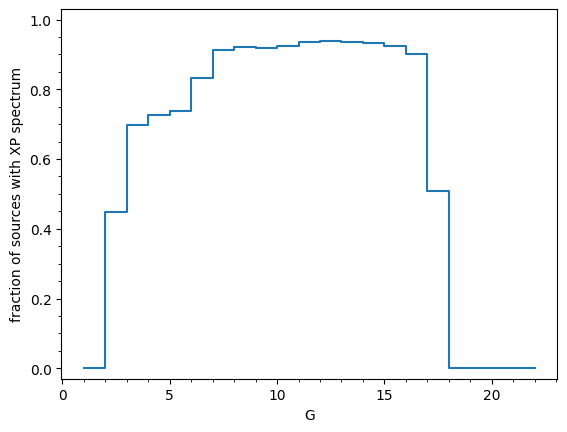

In [4]:
t_only_by_mag = t.group_by(['magnitude']).groups.aggregate(np.sum)

k_over_n = t_only_by_mag['k'] / t_only_by_mag['n']
plt.step( t_only_by_mag['magnitude']+3 , k_over_n , where='post')
plt.minorticks_on()
plt.xlabel('G')
plt.ylabel('fraction of sources with XP spectrum')
plt.ylim(-0.03,1.03)

The fraction of sources with an XP spectrum seems to be constant ~90% from magnitude 4 to 14, then drops to 0% quickly. Is this true everywhere on the sky? We can compute the completeness as a function of magnitude in different regions, and display them on the same plot to compare.

Text(0.5, 1.0, 'whole sky divided in 12 hpx0 regions')

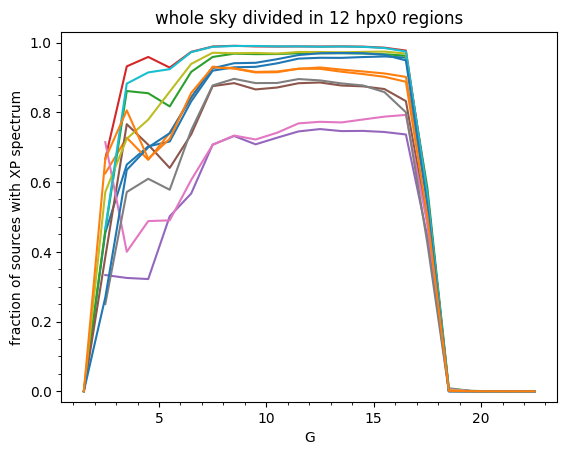

In [5]:
t_hpx0 = t.group_by(['magnitude','hpx0']).groups.aggregate(np.sum)


for hpxNb in range(12):
    t_this_hpx = t_hpx0[ t_hpx0['hpx0']==hpxNb ]
    k_over_n = t_this_hpx['k'] / t_this_hpx['n']
    plt.plot( t_this_hpx['magnitude'] + 3 + 0.5 , k_over_n )
    
plt.minorticks_on()
plt.xlabel('G')
plt.ylabel('fraction of sources with XP spectrum')
plt.ylim(-0.03,1.03)
plt.title('whole sky divided in 12 hpx0 regions')

From this we see that some regions are a lot more complete than others. Let's subdivide even more:

Text(0.5, 1.0, 'whole sky divided in 48 hpx1 regions')

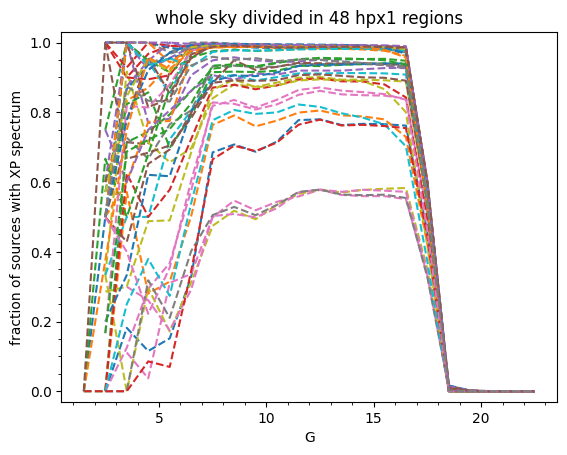

In [6]:
t_hpx1 = t.group_by(['magnitude','hpx1']).groups.aggregate(np.sum)


for hpxNb in range(48):
    t_this_hpx = t_hpx1[ t_hpx1['hpx1']==hpxNb ]
    k_over_n = t_this_hpx['k'] / t_this_hpx['n']
    plt.plot( t_this_hpx['magnitude'] + 3 + 0.5 , k_over_n , '--')
    
plt.minorticks_on()
plt.xlabel('G')
plt.ylabel('fraction of sources with XP spectrum')
plt.ylim(-0.03,1.03)
plt.title('whole sky divided in 48 hpx1 regions')

In any given region (here the twelve hpx0 regions) we can also visualise the completeness as a function of colour. Here we visualise the completeness as a function of colour and magnitude, in twelve regions of the sky:

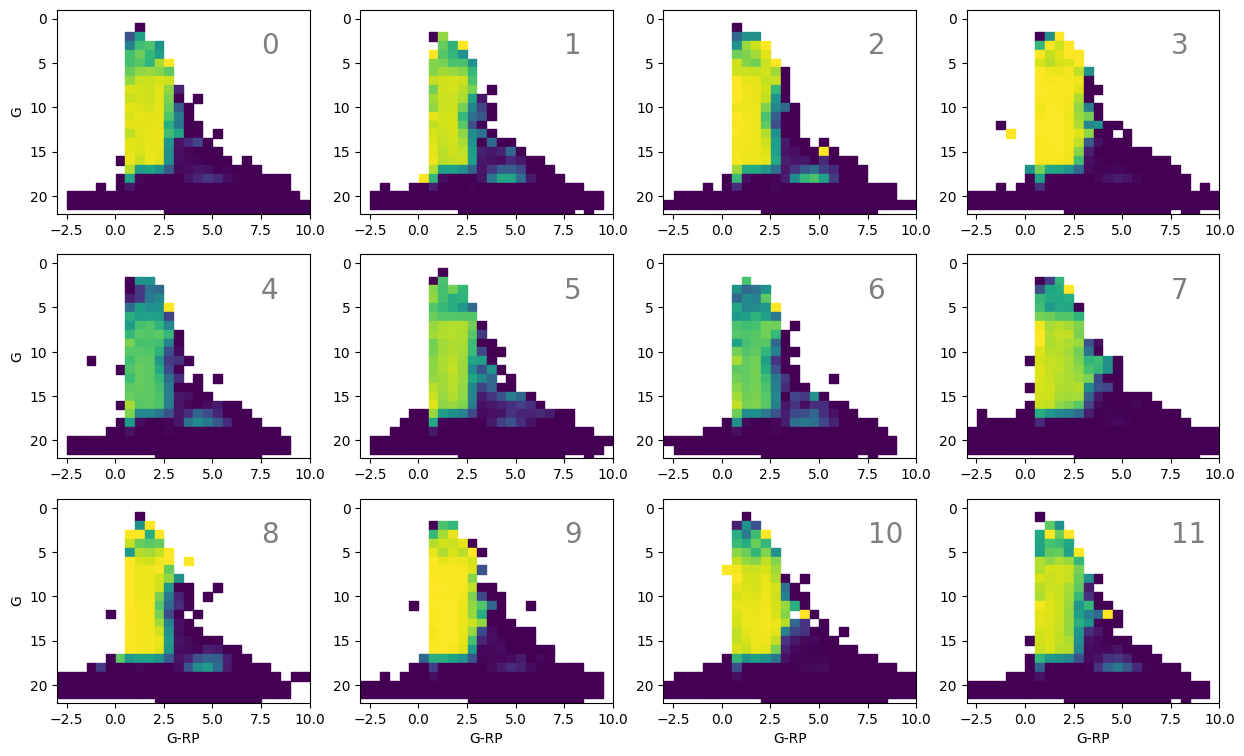

In [7]:
t_hpx0 = t.group_by(['magnitude','hpx0','colour']).groups.aggregate(np.sum)

plt.figure(figsize=(15,9))

for hpxNb in range(12):
    plt.subplot(3,4,hpxNb+1)
    t_this_hpx = t_hpx0[ t_hpx0['hpx0']==hpxNb ]
    k_over_n = t_this_hpx['k'] / t_this_hpx['n']
    
    plt.scatter( (t_this_hpx['colour']-2.5)*0.5 , t_this_hpx['magnitude']+3 , c=k_over_n ,
                vmin=0, vmax=1, marker='s',s=40)
    plt.ylim(22,-1)
    plt.xlim(-3,10)
    
    # add xlabel to the bottom row:
    if hpxNb+1>8:
        plt.xlabel('G-RP')
    # add ylabel to the left column:
    if hpxNb%4==0:
        plt.ylabel('G')
    # add healpix number
    plt.text(7.5,4,str(hpxNb),fontsize=20,alpha=0.5)
        

## All-sky maps

Let's look at the completeness over the whole sky, in a certain colour and magnitude bin.

magnitude bin number 12 corresponds to **G = 15 to 16**

colour bin number 5 is **(G-Rp) = 0.5 to 1**

In [8]:
t_colourMagnitudeBin = t[ (t['magnitude']==12) & (t['colour']==5) ]

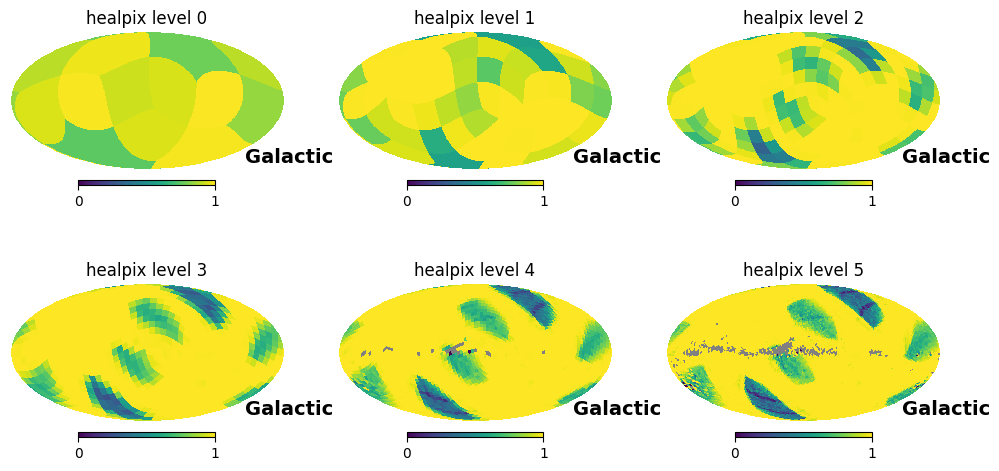

In [18]:
import healpy as hp

plt.figure(figsize=(12,6))

for lll,level in enumerate(['hpx0','hpx1','hpx2','hpx3','hpx4','position']):
    t_lowres = t_colourMagnitudeBin.group_by([level]).groups.aggregate(np.sum)
    ratios_lowres = t_lowres['k']/t_lowres['n']
    hpxNb_lowres = t_lowres[level]
    
    # Some might be empty, so we make a new list with the correct length and fill it:
    ratios_lowres_nogaps = np.empty(12*4**lll)
    ratios_lowres_nogaps[:] = np.nan
    for iii in range(len(ratios_lowres_nogaps)):
        try:
            ratios_lowres_nogaps[iii] = ratios_lowres[ t_lowres[level]==iii ][0]
        except:
            pass #we have no counts in there
        
    plt.subplot(2,3,lll+1)
    hp.mollview( ratios_lowres_nogaps , nest=True , coord='CG',hold=True,min=0,max=1,
               title='healpix level %i' % (lll) )

As we increase the resolution we run into the issue that some pixels do not contain any sources, so we can't compute the completeness as a ratio there. We can alleviate this problem by making larger colour bins (since there does not seem to be a strong colour dependence this could be a reasonable choice), or larger magnitude bins.

During the Torino GaiaUnlimited workshop we also discussed the idea of using a smoothing prior: in each pixel the posterior probability can be computed as `k+1/n+2` multiplied by the value of `K+1/N+2` computed for the parent healpix region. 